# cadCAD Tutorials: The Robot and the Marbles, part 3
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In this notebook we'll look at how subsystems within a system can operate in different frequencies. But first let's copy the base configuration with which we ended Part 2. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act simultaneously; in other words, they assess the state of the system at the exact same time, and decide what their action will be based on that information.

In [3]:
%%capture


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's omit it
sim_config_dict = {
    'T': range(10),
    'N': 1,
    #'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sH, s):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sH, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sH, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm,
            'robot_arm_2': robot_arm
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 





#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:] # Clear any prior configs

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
simulation = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

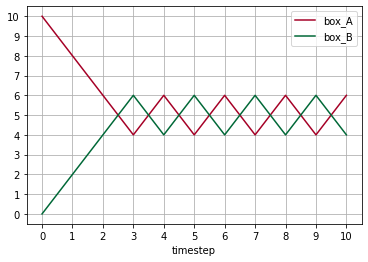

In [4]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Asynchronous Subsystems
We have defined that the robots operate simultaneously on the boxes of marbles. But it is often the case that agents within a system operate asynchronously, each having their own operation frequencies or conditions.

Suppose that instead of acting simultaneously, the robots in our examples operated in the following manner:
* Robot 1: acts once every 2 timesteps
* Robot 2: acts once every 3 timesteps

One way to simulate the system with this change is to introduce a check of the current timestep before the robots act, with the definition of separate policy functions for each robot arm.

In [5]:
%%capture

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify each of the robots logic in a Policy Function
robots_periods = [2,3] # Robot 1 acts once every 2 timesteps; Robot 2 acts once every 3 timesteps

def get_current_timestep(cur_substep, s):
    if cur_substep == 1:
        return s['timestep']+1
    return s['timestep']

def robot_arm_1(params, step, sH, s):
    _robotId = 1
    if get_current_timestep(step, s)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 2, Robot 1 acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

def robot_arm_2(params, step, sH, s):
    _robotId = 2
    if get_current_timestep(step, s)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 3, Robot 2 acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 2 doesn't interfere with the system


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

del configs[:] # Clear any prior configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

simulation_result = pd.DataFrame(raw_result)

<AxesSubplot:xlabel='timestep'>

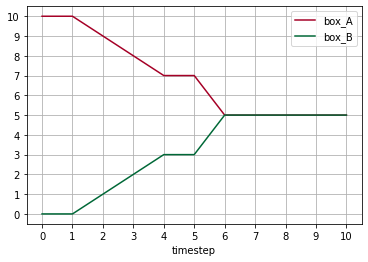

In [6]:
simulation_result.plot('timestep', ['box_A', 'box_B'], 
        grid=True, 
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+max(simulation_result['box_A'].max(),simulation_result['box_B'].max()))),
        colormap = 'RdYlGn'
       )

Let's take a step-by-step look at what the simulation tells us:
* Timestep 1: the number of marbles in the boxes does not change, as none of the robots act
* Timestep 2: Robot 1 acts, Robot 2 doesn't; resulting in one marble being moved from box A to box B
* Timestep 3: Robot 2 acts, Robot 1 doesn't; resulting in one marble being moved from box A to box B
* Timestep 4: Robot 1 acts, Robot 2 doesn't; resulting in one marble being moved from box A to box B
* Timestep 5: the number of marbles in the boxes does not change, as none of the robots act
* Timestep 6: Robots 1 __and__ 2 act, as 6 is a multiple of 2 __and__ 3; resulting in two marbles being moved from box A to box B and an equilibrium being reached.